## PREP-1: Install bgfc_kit package from github 
- Install instructions can be found on the repo

In [1]:
!pip install git+https://github.com/peetal/bgfc_kit.git

  Cloning https://github.com/peetal/bgfc_kit.git to /tmp/pip-req-build-u3na5dxa
  Running command git clone --filter=blob:none --quiet https://github.com/peetal/bgfc_kit.git /tmp/pip-req-build-u3na5dxa
  Resolved https://github.com/peetal/bgfc_kit.git to commit 8dbce79bce49aaf5195a33846dc0e8f6a7dcf79e
  Preparing metadata (setup.py) ... done
  Created wheel for bgfc-kit: filename=bgfc_kit-1.0.0-py3-none-any.whl size=16875 sha256=c838ac879ca166b0a15568e5edf85e0293012f305118e6592902d801613467d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-kne04beh/wheels/3e/e1/81/7dd1be24bc71a9a51a9aa83b1d8adb5f7618e5a3a44ba84e42
Successfully built bgfc-kit

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


- Here we can see that the package has been successfully installed, and we can also check the submodules of the package.

In [2]:
import bgfc_kit, importlib, inspect, pkgutil, os
package = importlib.import_module('bgfc_kit')
print(f"Submodules of bgfc_kit:")
for loader, name, is_pkg in pkgutil.walk_packages(package.__path__):
    print(f"- {name}")

Submodules of bgfc_kit:
- bgfc_analyses
- fir_design_matrix
- preprocessing_pipeline
- structDict


## PREP-2: Dummy experimental Design 
- Here I introduce a dummy exprimental design that mirror the design of Chapter 3, the goal is demonstrate how to use `bgfc_kit` for backgrounf connectivity analyses
- 6 conditions, 2 functional runs per condition; 8 epochs (of the same condition) per functional run.
- Run structure: 6 TR leading-in + 40 TR/epoch * 8 epoch + 6 TR leading-out -> 332 TR/run 
- Epoch structure: 4 TR instruction + 24 TR tasks + 12 TR IBI -> 40 TR/epoch
- We chose to use FIR to model the first 36 TR of each epoch of each condition -> 36 TR * 6 condition = 216 regressors

## 1. Finite impulse response (FIR) model design matrix 
#### 1.1 Creating configuration file template
- Generating the FIR model design matrix needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters to generate the design matrix. After you fill it out, it can be reused to generate FIR model design matrices easily.
- Here we can use `generate_FIRdesignMat_template_toml` function from `bgfc_kit.fir_design_matrix` to generate a template of configuration file.

In [14]:
from bgfc_kit.fir_design_matrix import generate_FIRdesignMat_template_toml
# generate an the template configuratio file
output_dir = '/projects/hulacon/peetal/bgfc_kit_test/'
generate_FIRdesignMat_template_toml(output_dir)

- Let's have a quick look at the configuration file template
    - The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
    - The `COMMENTS` explains what each parameter is.
  
      <img src="designmat_config.png" width="600" height="500">


#### 1.2 Generating FIR model design matrix for a subject 
- The `write_personalized_FIRdesignMat` takes account of excessive motion and remove bad frame or runs (such as the last run in the current case. 
- Simpler version `write_vanilla_FIRdesignMat` can be used if no need to consider motions.
- This function writes out the design matrix to the output directory and also plot the corresponding heatmap for visual inspection.
    - Each role is a TR, there are 332 TR/run * 12 run = 3984 TR.
    - Each column is a FIR regressor, each regressor models a TR of all epochs within the same condition. As suggested in the dummy design, we model the first 36 TR of all epochs, and there are 6 conditions, and thus we have 216 FIR regressors.
    - Note that due to the size of the figure, not all names of the regressors were shown. 


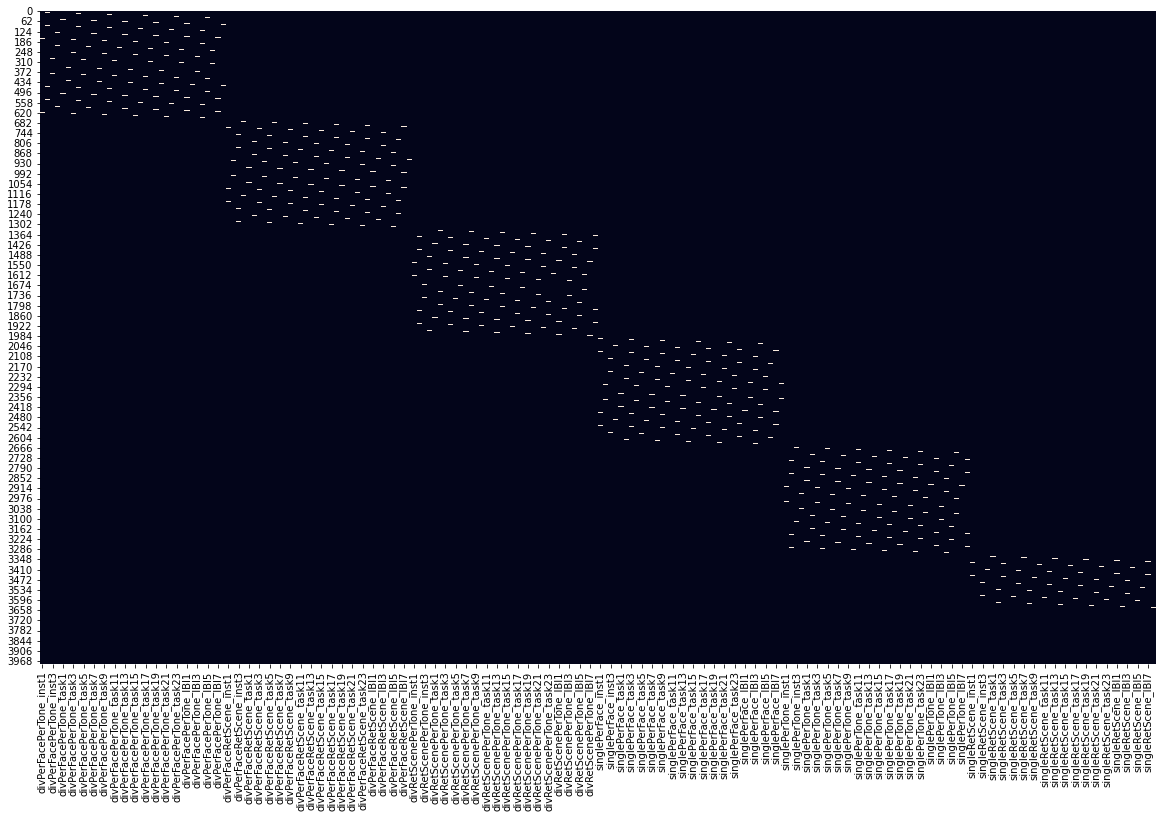

In [38]:
from bgfc_kit.fir_design_matrix import write_personalized_FIRdesginMat
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
write_personalized_FIRdesginMat(cfg_dir, output_dir)

## 2. BGFC preprocessing pipeline

The module within BGFC-kit responsible for extracting the residual timeseries is intended to complement the preprocessing pipeline of fMRIprep (Esteban et al., 2019). Utilizing the minimally preprocessed NIFTI files and the confound parameter estimates generated by fMRIprep, BGFC-kit carries out additional preprocessing steps. These steps include: 
1) smoothing and filtering (orange box)
2) applying a first general linear model (GLM) to eliminate nuisance regressors (blue box)
3) demeaning and concatenation (green box) 
4) employing a second GLM to eliminate stimulus-evoked activities (pink box)

The outputs of BGFC-kit preprocessing pipeline includes 4 important components: 
1) the "residual" timeseries, which can then be used for computing background functional connectivity
2) the "evoked" timeseries, which is the concatenated timeseries prior to the second GLM
3) the parameter estimates of the second GLM, which can be used to perform sanity check
4) a brain mask for the subject shared across all fMRI functional runs.

<img src="pipeline_graph.png" width="700">

#### 2.1 Creating configuration file template
- Running this postfMRIprep pipeline needs many specific inforamtion about the task design. These information can be too chunky to include in a single function. 
- So you can first create an empty configuration file with all necessary parameters for running the pipeline. After you fill it out, it can be reused to generate FIR model design matrices easily.
- Here we can use `generate_postfMRIprep_pipeline_template_toml` function from `bgfc_kit.preprocessing_pipeline` to generate a template of configuration file.

In [43]:
from bgfc_kit.preprocessing_pipeline import generate_postfMRIprep_pipeline_template_toml
generate_postfMRIprep_pipeline_template_toml(output_dir)

- Let's have a quick look at the configuration file template
    - The `PARAMETERS` are empty and will take your inputs that are specific to your experiment design. 
    - The `COMMENTS` explains what each parameter is.
      
        <img src="firpip_config.png" width="600" height="500">

#### 2.2 Submit SLURM job to talapas

- This feature is specifically useful for talapas users. The `submit_postfMRIprep_pipeline_SLURM` function from `bgfc_kit.preprocessing_pipeline` will write out a shell script and submit a slurm job automatically through subprocess.
- We can examine or edit the shell script automatically generated by this function if necessary.

In [2]:
from bgfc_kit.preprocessing_pipeline import submit_postfMRIprep_pipeline_SLURM
cfg_dir = '/projects/hulacon/peetal/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
shell_dir = '/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh'
submit_postfMRIprep_pipeline_SLURM(cfg_dir, shell_dir, "hulacon", "fat", "post_fmriprep", "100GB")

Bash script submitted successfully.
Job ID: Submitted batch job 29548876


In [44]:
with open('/projects/hulacon/peetal/bgfc_kit_test/submit_postfMRIprep_test.sh', 'r') as file:
    script_content = file.read()

# Print the content of the shell script
print(script_content)

#!/bin/bash
#SBATCH --account=hulacon
#SBATCH --partition=fat  
#SBATCH --job-name=post_fmriprep  
#SBATCH --mem=100GB
#SBATCH --time=1-00:00:00
#SBATCH --output=%x_%A_%a.log

module load fsl
module load ants
module load miniconda
module load singularity
conda activate jupyterlab-tf-pyt-20211020

python3 /gpfs/projects/hulacon/peetal/bgfc_kit/bgfc_kit/scripts/post_fMRIPrep_pipeline.py --sub-id 001 --task-id divPerFacePerTone_run-1 divPerFacePerTone_run-2 divPerFaceRetScene_run-1 divPerFaceRetScene_run-2 divRetScenePerTone_run-1 divRetScenePerTone_run-2 singlePerFace_run-1 singlePerFace_run-2 singlePerTone_run-1 singlePerTone_run-2 singleRetScene_run-1 singleRetScene_run-2  --space T1w --base-dir /projects/hulacon/peetal/divatten --output-dir /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data --designMat-dir /projects/hulacon/peetal/bgfc_kit_test/fir_design_matrix.txt --run-restTR 38 39 40 41 42 43 44 45 46 47 48 49 78 79 80 81 82 83 84 85 86 87 88 89 118 119 120 121 122 123 124 1

#### 2.3 Examine the outputs from the postfMRIprep pipeline
- Once the job is done, we can examine the key outputs from this pipeline.
1) the "residual" timeseries -> `FIR_residual/sub-001_res.nii.gz`
2) the "evoked" timeseries -> `before_FIR/sub-001_nuisanceRes_CONCAT.nii.gz`
3) the parameter estimates of the second GLM -> `FIR_betas/sub-001_beta.nii.gz`
4) a brain mask for the subject shared across all fMRI functional runs -> `task_shared_mask/sub-001_task-shared_brain-mask.nii.gz`

In [39]:
!tree /projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001

/projects/hulacon/peetal/bgfc_kit_test/preprocessed_data/sub-001
├── FIR_betas
│   └── sub-001_beta.nii.gz
├── FIR_residual
│   └── sub-001_res.nii.gz
├── before_FIR
│   └── sub-001_nuisanceRES_CONCAT.nii.gz
├── nuisance_regressor
│   ├── sub-001_task-divPerFacePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFacePerTone_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFaceRetScene_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divPerFaceRetScene_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divRetScenePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-divRetScenePerTone_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerFace_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerFace_run-2_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-singlePerTone_run-1_desc-confounds_timeseries_selected.csv
│   ├── sub-001_task-

## 3. Compute background functional connectivity (BGFC) matrices from residual timeseries
#### 3.1 Dimension reduction through parcelltion. 
- Now the residual timeseries is 4d, with the last dimension being time (3984 in this case). Voxel-wise BGFC matrices can be too computational intensive. So here we will first apply a user selected predefined parcelaltion scheme for dimension reduction. 
- One can use the `parcellate_rmMotion_batch` function in `bgfc_kit.bgfc_analyses` submodule to parcellate the brain into predefined parcels. In this example, I'm using the Schaefer 200 parcellation scheme. Consequently, this function would reduce the dimension into 200 x 3984.
- As expected, the shape of the output `activity_data` is (1 x 200 x 3984), with 1 being the number of subject we are currently working on. 

In [10]:
from bgfc_kit.bgfc_analyses import parcellate_rmMotion_batch
activity_data = parcellate_rmMotion_batch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, subject_list, atlas)

# For the purpose of benchmarking shape onyl. 
print(f"The shape of the residual timeseries after dimension reduction is {activity_data.shape}, which is (nSub, nParcel, nTR)")

The shape of the residual timeseries after dimension reduction is (1, 200, 3984), which is (nSub, nParcel, nTR)


#### 3.2 Divide the full timeseries into epoch structures
- The residual timeseires has 3984 TR with the dummy experimental design. Now we need to divide it into epochs consisting of 40 TRs each.
- Using the `define_epoch` function, we could specify the TRs associated with each epoch, and the condition of each epoch.
- Next using the `separate_epochs` function, we could divide the full residual timeseries into epochs
- Then using the `separate_epochs_per_condition` function, we could separate epochs by conditions

In [30]:
from bgfc_kit.bgfc_analyses import define_epoch, separate_epochs, separate_epochs_per_condition

# define epoch and condition structure (which TR belongs to which epoch/condition) 
single_epoch = define_epoch(FIRdesignMat_conf_dir, postfMRIprep_conf_dir)

# separate the full timeseires into epoch 
sub_epoch = [single_epoch for i in range(len(subject_list))]
raw_data, labels = separate_epochs(activity_data, sub_epoch)
# print(f"'labels' shows the condition for each set of epoch, there are 6 conditions and 1 subject, so the length is 6*1 = {len(labels)}") 
# print(f"'raw_data' contains epoch data of a condition per subject, the shape of epoch data is {raw_data[0].shape}, which is (nParcel, nTR/epoch(40)*nEpoch/cond(16))")

# put together all epochs of the same condition 
cond1 = separate_epochs_per_condition(raw_data,labels,0,sub_epoch)
cond2 = separate_epochs_per_condition(raw_data,labels,1,sub_epoch)
cond3 = separate_epochs_per_condition(raw_data,labels,2,sub_epoch)
cond4 = separate_epochs_per_condition(raw_data,labels,3,sub_epoch)
cond5 = separate_epochs_per_condition(raw_data,labels,4,sub_epoch)
cond6 = separate_epochs_per_condition(raw_data,labels,5,sub_epoch)
print(f"For each condition, there are data of {len(cond1)} subject, the data has the shape of {cond1[0].shape}, which is (nEpoch/cond, nParcel, nTR/epoch)")

For each condition, there are data of 1 subject, the data has the shape of (16, 200, 40), which is (nEpoch/cond, nParcel, nTR/epoch)


#### 3.3 Compute BGFC matrices
- bgfc_kit offers 2 ways for computing BGFC matrices. The first is to do epoch-level computation using the `compute_epoch_cond_connectome_ztrans_nobadframe` function, so each subject will end up having 96 BGFC matrices over the 6 conditions with the current dummy experimental design. The second is to do subject-level computation using the `compute_sub_cond_connectome_ztrans_nobadframe` function, so each subject will only have 1 BGFC matrices.
- Additionally, one can use the `vectorize_connectome` function to obtain the vectorized connectome, this can be useful for training machine learning models.
- They can all serve different purposes of different subsequent analyses. Here I am showing example of doing just 1 condition. 

In [38]:
from bgfc_kit import compute_epoch_cond_connectome_ztrans_nobadframe, compute_sub_cond_connectome_ztrans_nobadframe, vectorize_connectome
# compute connectome for each epoch for all subjects, geting a list of epochs 
cond1_epochlevel_corMat = compute_epoch_cond_connectome_ztrans_nobadframe(cond1)
cond1_epochlevel_edges = vectorize_connectome(cond1_epochlevel_corMat)
print(f"The epoch level computation results {len(cond1_epochlevel_corMat[0])} matrices per subject")

# compute epoch-averaged connectome all subjects, geting a list of epochs 
cond1_sublevel_corMat = list(compute_sub_cond_connectome_ztrans_nobadframe(cond1))
print(f"The subject level computation results {len(cond1_sublevel_corMat)} matrices per subject")

The epoch level computation results 16 matrices per subject
The subject level computation results 1 matrices per subject


## 4. Potential subsequent analyses
#### 4.1. Sanity check: FIR regressor estimates
- FIR estimates can be used for sanity check.
- Using the `plot_parcel_FIR_estimates` function from `bgfc_kit.bgfc_analyses`, we will be able to plot the FIR estimates for any parcel of interests. Importantly, with the current dummy experimental design, the 216 FIR regressors models 6 types of epochs, with each type of epoch including 24 TR task and 12 TR rest. Consequently, if everything goes well, we should be able to observe boxcar structure when we plot out the estimates.
- Here I used the Schaefer 200 predefined parcellation scheme, and selected parcel 1 to look at. It is in the visual network. Note that the selection of the parcellation scheme and parcels are completely up to the user.
- From the plot we can see the clear boxcar shape. Note that this is from 1 subject, when more subjects' data were added together, the shape will become even clearer. 

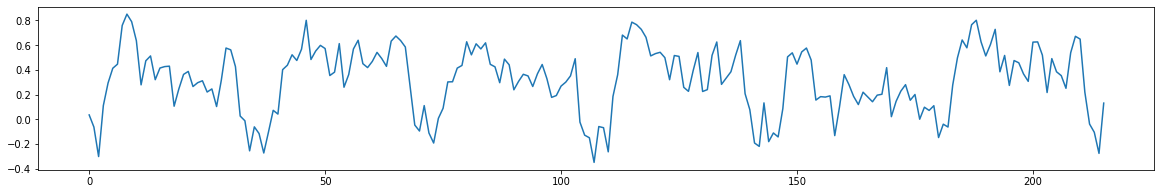

In [7]:
from bgfc_kit.bgfc_analyses import plot_parcel_FIR_estimates

# specify the necessary inputs
FIRdesignMat_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/FIRdesignMat_conf_filled.toml'
postfMRIprep_conf_dir = '/home/peetal/hulacon/bgfc_kit_test/postfMRIprep_pipeline_config_filled.toml'
atlas = '/home/peetal/hulacon/bgfc_kit_test/schaefer200_atlas.nii.gz'
subject_list = [1] # we only look at the first subject we have just preprocessed

# Check the FIR estimates of parcel 1 in the schaefer parcellation scheme. 
plot_parcel_FIR_estimates(FIRdesignMat_conf_dir, postfMRIprep_conf_dir, 1, [1], atlas)

#### 4.2. Graph theory analyses
- There are various graph theory analyses that can be performed. Here I'm showing an example of computing participation coefficient of each brain network under condition 1. The participation coefficient measure was computed over 5 different threshold.
- One can use `construct_graphs()` function to construct graphs from BGFC matrices, and use `construct_threshold_binary_graphs()` for computing binary graphs using different thresholds.
- One can then use `participation_coefficient()` function to compute PC for each parcel and use `compute_network_pc()` function to compute network level PC

In [55]:
from bgfc_kit import construct_graphs, construct_threshold_binary_graphs, participation_coefficient

# schaefer_partition is a default dict, keys are network names, values are parcel ids
schaefer200_partition = pd.read_csv('/projects/hulacon/peetal/divatten/preprocess/schaefer200_7net_label.tsv', sep='\t', index_col=False)
schaefer_net = [name.split('_')[2] for name in schaefer200_partition['name'].tolist()] # network assignemnt for each parcel 
schaefer_partition = defaultdict(set) # list of sets of schaefer nodes
for parcel, net in enumerate(schaefer_net): 
    schaefer_partition[net].add(str(parcel))

# construct graphs and compute modularity measure over multiple thresholds 
cond1_pc = []
for density in [5, 10, 15, 20, 25]: 
    
    # construct binary graph
    cond1_graphs = construct_threshold_binary_graphs(cond1_sublevel_corMat, density)
    
    # compute modularity for each graph 
    parcel_pc = [participation_coefficient(G, schaefer_partition) for G in cond1_graphs]
    network_pc = [compute_network_pc(pc, schaefer_partition) for pc in parcel_pc]
    cond1_pc.append(network_pc)
    
# shape is (nSub, 7); 7 networks ('Vis','SomMot','DorsAttn','SalVenAttn','Limbic','Cont','Default')
cond1_pc = np.mean(cond1_pc, axis = 0)
print(f"The PC measures of condition1 for networks {list(schaefer_partition.keys())} are {list(cond1_pc[0])}")

The PC measures of condition1 for networks ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default'] are [0.5830645500976519, 0.6015412194089729, 0.8608183782586792, 0.8642642657355282, 0.4816837927018833, 0.7845806902583183, 0.47843499538262213]


#### 4.3. Training machine learning models
- There are many ways one could train machine learning models to perform a variety of tasks. Consequently, it is impractical to provide specific wrapper function in bgfc_kit. However, I provide some code for specific examples of using machine learning on BGFC analyses.
- Example 1:
    - This example aims to use a leave-one-subject-out cross validation framework to separate 2 classes of conditions (divided vs. non-divided attention conditions) based on the BGFC computed for each parcel. The training data was balanced to make sure there were the same number of samples within each class. Given the abundance of features within a connectivity matrix, principal component analysis (PCA) is initially performed on all BGFC matrices in the training set. The top 500 principal components are then utilized to train a regularized generalized linear model (e.g., softmax) to distinguish between selected task conditions, which is subsequently tested on epochs from the left-out subject in each fold. 

In [ ]:
class Parcel_singleVSdiv():
    
    def __init__(self, data, num):
        """
        data: a list of 6 conditions, each condtion is a list of connectomes for all epochs of all subjects
        num: a list of 6 conditions, each condition is a list of # of connectomes (i.e., epoch) per subjects 
        """
        self.perface, self.pertone, self.retscene = data[0],data[1],data[2]
        self.perface_pertone, self.perface_retscene, self.retscene_pertone = data[3], data[4], data[5]
        
        self.perface_num, self.pertone_num, self.retscene_num = [],[],[]
        self.perface_pertone_num, self.perface_retscene_num, self.retscene_pertone_num = [],[],[]
        
        # use dp to make generating testing/training idx faster 
        for sub in range(len(num[0])+1):
            self.perface_num.append(int(np.sum(num[0][:sub])))
            self.pertone_num.append(int(np.sum(num[1][:sub])))
            self.retscene_num.append(int(np.sum(num[2][:sub])))
            self.perface_pertone_num.append(int(np.sum(num[3][:sub])))
            self.perface_retscene_num.append(int(np.sum(num[4][:sub])))
            self.retscene_pertone_num.append(int(np.sum(num[5][:sub])))
        
    def _prepare_data(self, parcel_id):
        
        self.perface_seedmap = [epoch[parcel_id, :] for epoch in self.perface]
        self.pertone_seedmap = [epoch[parcel_id, :] for epoch in self.pertone]
        self.retscene_seedmap = [epoch[parcel_id, :] for epoch in self.retscene]
        self.perface_pertone_seedmap = [epoch[parcel_id, :] for epoch in self.perface_pertone]
        self.perface_retscene_seedmap = [epoch[parcel_id, :] for epoch in self.perface_retscene]
        self.retscene_pertone_seedmap = [epoch[parcel_id, :] for epoch in self.retscene_pertone]
    
    def _train_test_split(self, test_id): 
        
        def _split_cond(cond_seedmap, cond_num, test_id): 
            
            testing_idx = range(cond_num[test_id], cond_num[test_id+1])
            training_idx = set(range(len(cond_seedmap))) - set(testing_idx)
            
            cond_training = [cond_seedmap[i] for i in training_idx]
            cond_testing = [cond_seedmap[i]for i in testing_idx]
            return cond_training, cond_testing 
        
        # train test split for each fold 
        perface_training, perface_testing = _split_cond(self.perface_seedmap, self.perface_num, test_id)
        pertone_training, pertone_testing = _split_cond(self.pertone_seedmap, self.pertone_num, test_id)
        retscene_training, retscene_testing = _split_cond(self.retscene_seedmap, self.retscene_num, test_id)
        perface_pertone_training, perface_pertone_testing = _split_cond(self.perface_pertone_seedmap, self.perface_pertone_num, test_id)
        perface_retscene_training, perface_retscene_testing = _split_cond(self.perface_retscene_seedmap, self.perface_retscene_num, test_id)
        retscene_pertone_training, retscene_pertone_testing = _split_cond(self.retscene_pertone_seedmap, self.retscene_pertone_num, test_id)
        
        # make sure the n_samples for each training category is the same 
        single_training = perface_training+pertone_training+retscene_training
        div_training = perface_pertone_training+perface_retscene_training+retscene_pertone_training
        single_testing = perface_testing+pertone_testing+retscene_testing
        div_testing = perface_pertone_testing+perface_retscene_testing+retscene_pertone_testing
        if len(single_training)>len(div_training): 
            single_training = random.sample(single_training, len(div_training))
        elif len(single_training)<len(div_training): 
            div_training = random.sample(div_training, len(single_training))
        self.data_training = single_training + div_training 
        self.label_training = np.repeat([0,1],len(single_training))
        self.data_testing = single_testing + div_testing 
        self.label_testing = np.concatenate((np.repeat(0,len(single_testing)), np.repeat(1,len(div_testing))))
    
    def _parcel_model_performance(self, parcel_id): 
        
        self._prepare_data(parcel_id)
        self.pipe = pipe = Pipeline([('scaler',preprocessing.StandardScaler()),
                                     ('logistic',LogisticRegression(penalty = "l2",C=0.1, max_iter=5000, multi_class = "multinomial"))])
        parcel_acc = []
        for sub in range(len(self.perface_num)-1): # for each fold/subject
            self._train_test_split(sub) # train test split for the fold 
            self.pipe.fit(self.data_training, self.label_training)
            parcel_acc.append(self.pipe.score(self.data_testing, self.label_testing))
        return np.mean(parcel_acc)
    
    def _parcel_model_predprob(self, parcel_id): 
        
        self._prepare_data(parcel_id)
        self.pipe = pipe = Pipeline([('scaler',preprocessing.StandardScaler()),
                                     ('logistic',LogisticRegression(penalty = "l2",C=0.1, max_iter=5000, multi_class = "multinomial"))])
        parcel_prob = []
        parcel_label = []
        for sub in range(len(self.perface_num)-1): # for each fold/subject
            self._train_test_split(sub) # train test split for the fold 
            self.pipe.fit(self.data_training, self.label_training)
            parcel_prob.append(self.pipe.predict_proba(self.data_testing))
            parcel_label.append(self.label_testing)
        return parcel_prob, parcel_label
    
    def compute_parcel_singlVSdiv_attention_score(self): 
        
        parcel_singleVSdiv_atten_score = []
        for p in range(self.perface[0].shape[0]): # for each parcel 
            parcel_singleVSdiv_atten_score.append(self._parcel_model_performance(p))
        
        return parcel_singleVSdiv_atten_score
    
    def compute_parcel_singlVSdiv_attention_proba(self):
        
        pred_proba, test_labels = {}, {}
        for p in range(self.perface[0].shape[0]): # for each parcel 
            pred_proba[p+1], test_labels[p+1] = self._parcel_model_predprob(p)
        
        return pred_proba, test_labels
